## Corpus Cleanup using Vector Space and Unsupervised Learning Methods

Here we aim to further remove noisy words from the MSA words corpus, by using vector space and unsupervised learning methods. This approach is at root non-linguistic, i.e. language agnostic.

In a nutshell, the idea is to represent words as numeric vectors (features) using **bag of ngrams** method, and perform various operations on words in this vector space. Specifically, we will reduce the dimensionality of the vector space, and identify anomalous points (i.e. words).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set the font size of plots
plt.rcParams['font.size'] = 14

In [4]:
np.set_printoptions(precision=3)

In [5]:
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer

In [6]:
from sklearn.preprocessing import normalize

## Load word data from file

In [7]:
filename = '../../results/Arabic_words_corpus_final.csv'
df = pd.read_csv(filename, names=['word','lang_label'],header=None)
df.head()

,word,lang_label
0,آئ,MSA
1,آب,MSA
2,آباء,MSA
3,آبائه,MSA
4,آبائهم,MSA


In [10]:
df.lang_label.value_counts()

MSA    46895
TN       787
Name: lang_label, dtype: int64

In [9]:
msa_words_corpus = df[df.lang_label=="MSA"]
msa_words_corpus.shape

(46895, 2)

****

## Vector-Space representation of words
using Bag-of-ngrams ...

In [404]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [405]:
# Important hyperparameter: maximum order of ngram features
N = 3

In [406]:
# Notice the option analyzer='char_wb'
#vectorizer = TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, N), analyzer='char_wb')
vectorizer = CountVectorizer(min_df=1, max_df=0.9, ngram_range=(1, N), analyzer='char_wb')

#### Calculate DTM matrix

In [407]:
words_features_mat = vectorizer.fit_transform(msa_words_corpus.word.tolist())
type(words_features_mat), words_features_mat.shape

(scipy.sparse.csr.csr_matrix, (40927, 12108))

In [408]:
words_features_mat.min(),words_features_mat.max()

(0, 4)

In [409]:
words_features_mat.nnz/words_features_mat.shape[0]/words_features_mat.shape[1]*100

0.14186305059467197

In [410]:
feature_names = np.asarray(vectorizer.get_feature_names())
type(feature_names),feature_names.shape

(numpy.ndarray, (12108,))

*****

## Dimensionality Reduction

Tentative Methods:

- Heuristic method: remove rare features
- Non-linear dimensitionality reduction with t-SNE
- Linear dimensionality reduction via PCA

### Heuristic: remove rare features
Rare features are those that occur less than *threshold* times in the corpus. For now we use *threhsold*=1.

In [411]:
# Put properties of features in a data frame for convenience

feature_properties_df = pd.DataFrame({'feature':feature_names})

feature_properties_df['df'] = np.array((words_features_mat>0).sum(axis=0)).ravel()
feature_properties_df['relative_df'] = (1.0/words_features_mat.shape[0])*feature_properties_df.df
feature_properties_df['max_tf'] = words_features_mat.max(axis=0).toarray().ravel()

feature_properties_df.head()

,feature,df,relative_df,max_tf
0,آ,101,0.002468,1
1,آئ,1,0.000024,1
2,آب,7,0.000171,1
3,آت,3,0.000073,1
4,آث,10,0.000244,1


In [412]:
feature_properties_df.sort_values(by='df', ascending=False).head(10)

,feature,df,relative_df,max_tf
1851,ا,25622,0.626041,4
8675,ل,20440,0.499426,4
11485,ي,13796,0.337088,3
2329,ال,13576,0.331713,2
10769,و,12955,0.316539,3
9476,م,11773,0.287659,3
3107,ت,11751,0.287121,3
5100,ر,11414,0.278887,2
85,ا,11151,0.272461,1
112,ال,9845,0.240550,1


In [413]:
feature_properties_df.sort_values(by='df', ascending=True).head()

,feature,df,relative_df,max_tf
6053,سوخ,1,0.000024,1
4878,دلى,1,0.000024,1
4889,دمك,1,0.000024,1
4898,دنس,1,0.000024,1
11733,يرع,1,0.000024,1


In [414]:
feature_properties_df.corr()

,df,relative_df,max_tf
df,1.0000,1.0000,0.5903
relative_df,1.0000,1.0000,0.5903
max_tf,0.5903,0.5903,1.0000


In [415]:
feature_properties_df.describe()

,df,relative_df,max_tf
count,12108.000000,12108.000000,12108.000000
mean,58.060291,0.001419,1.012389
std,505.744575,0.012357,0.120618
min,1.000000,0.000024,1.000000
25%,3.000000,0.000073,1.000000
50%,8.000000,0.000195,1.000000
75%,24.000000,0.000586,1.000000
max,25622.000000,0.626041,4.000000


In [416]:
# sns.pairplot(feature_properties_df)

In [417]:
# TO DO: plot CDF of feature_properties_df.df

(feature_properties_df.df==1).sum(),(feature_properties_df.df==2).sum(),(feature_properties_df.df==3).sum()

(1784, 1165, 831)

In [418]:
# Identify rare features
bool_vect = feature_properties_df.df==1
indices = np.where(bool_vect)[0]

In [419]:
# Number of rare features to be removed
len(indices)

1784

In [420]:
# length distribution of these rare features
feature_properties_df[bool_vect].feature.map(len).value_counts()

3    1750
2      34
Name: feature, dtype: int64

In [421]:
# List of rare features to be removed
# print(feature_properties_df[bool_vect].feature.tolist())

In [422]:
# Random sample of 100 of these rare features

print(feature_properties_df[bool_vect].feature.sample(n=100).tolist())

[' دة', ' آك', 'عمن', 'دلك', 'صدة', 'يثأ', 'صيق', 'رقق', 'قرم', 'لئل', 'كذ ', 'مرر', 'رسع', ' ضت', 'نسة', 'صدع', 'بثه', 'رهت', 'هنك', 'لؤه', 'باص', 'ضتا', 'أيب', 'نتط', 'أقض', 'إرج', 'ءمة', 'ورخ', 'سحن', 'مغب', 'عص ', 'تؤس', 'بثت', 'اذل', 'مزب', 'وئه', 'طىء', 'عهن', 'يهج', 'شطا', 'أرخ', 'ءون', 'نيخ', 'يظف', 'ردش', 'شفط', 'إا', 'بطع', 'هئي', 'ضئ ', 'بكأ', 'خاك', 'قوه', 'قرئ', 'ذيع', 'دبث', 'أفن', 'إرب', 'يضخ', 'حح ', 'جرؤ', 'هنت', 'أظف', 'قتذ', 'فث', 'رجس', 'آها', 'للؤ', 'تعش', 'رثى', 'بثم', 'أضخ', 'برؤ', 'فحل', 'حقك', 'سلى', 'تضف', 'سوغ', 'أك ', 'وإغ', 'ذلا', 'رصو', 'ضنة', 'نزه', 'ثرى', 'طام', 'بشغ', 'حلك', 'خفت', 'عاظ', 'وثر', 'طئه', 'نحط', ' صت', 'نغه', 'وسح', 'ربص', 'كثب', 'تضت', 'يقذ']


In [423]:
# Select words that contain rare features

# number of rare features in each word
nb_rare_features_per_word = np.array((words_features_mat[:,indices]).sum(axis=1)).ravel()
type(nb_rare_features_per_word), nb_rare_features_per_word.shape

(numpy.ndarray, (40927,))

In [424]:
pd.Series(nb_rare_features_per_word).value_counts()

0    39331
1     1455
2      101
3       34
4        5
5        1
dtype: int64

In [438]:
## Words that contain rare features

# Number of these words
print((nb_rare_features_per_word>=1).sum())

# List of these words
# print(msa_words_corpus[nb_rare_features_per_word>=1].word.tolist())

# Random sample of 200 of these words
print(msa_words_corpus[nb_rare_features_per_word>=1].word.sample(n=200).tolist())

1596
['بظروف', 'أشمل', 'ضمها', 'غز', 'فبراير', 'استفزاز', 'قلج', 'وهشام', 'الإخشيد', 'الدؤوب', 'بدءوا', 'سبقوه', 'مهنته', 'نسعى', 'غدت', 'يشأ', 'الإعياء', 'أدرى', 'تؤسس', 'جة', 'أث', 'يسئ', 'لوذريق', 'ذياب', 'كنوز', 'إقمار', 'تفنى', 'الألفبائي', 'فتزوجها', 'تكذبني', 'المعتضد', 'حزنت', 'الإغماء', 'حفظكم', 'تساءلت', 'وزكاة', 'اللفظية', 'بحثت', 'غيض', 'يؤشر', 'بكأس', 'أخو', 'ضفاف', 'راسلنا', 'دحلان', 'كمسلمين', 'الأفطس', 'وهتك', 'ثالثهما', 'شنت', 'الدردري', 'القضبان', 'رامز', 'الليمفاوية', 'يء', 'فأذن', 'بيضتان', 'الإكتئاب', 'تعكف', 'وأردف', 'ابومعاشي', 'ورئيس', 'الضجر', 'أعطني', 'تبصر', 'الحضيض', 'استفدت', 'بوش', 'تغتسل', 'التآمر', 'قزوين', 'آد', 'المفلس', 'أقضي', 'آه', 'تضفي', 'يبطئ', 'ووحدة', 'البغاء', 'بأغلبية', 'قحطان', 'التأقلم', 'أدفع', 'أتأمل', 'المغص', 'هرقل', 'الاوعية', 'إقفال', 'وضد', 'جت', 'الإعتماد', 'المواعظ', 'نوضح', 'علشان', 'تحطمت', 'فمي', 'إرجاع', 'مأرب', 'كدش', 'ترفرف', 'برغر', 'سأقول', 'قبضه', 'القاوقجي', 'إشغال', 'يضخ', 'ساذجة', 'خطئه', 'مازيمبي', 'زخم', 'وسئل', 'صت',

******

### Non-linear dimensionality reduction with t-SNE

Actually, this is really a visualization method ... does not work on out-of-sample data ...

Yellowbrick's ``yellowbrick.text`` module contains two text visualizers:
- Token Frequency Distribution (``FreqDistVisualizer``): plot the frequency of tokens in a corpus.
- t-SNE Corpus Visualization (``TSNEVisualizer``): plot similar documents closer together to discover clusters.

Reference: https://www.districtdatalabs.com/text-analytics-with-yellowbrick/

In [94]:
X = words_features_mat
X.shape

(189514, 15331)

In [95]:
## Apply length normalization on row vectors of X so that cosine similarity becomes equivalent to euclidean distance

# X_norm = normalize(X, norm='l2', axis=1, copy=True, return_norm=False)
# type(X_norm),X_norm.shape

In [96]:
if False:
    visualizer = FreqDistVisualizer(features=feature_names)
    visualizer.fit(words_features_mat)
    visualizer.poof()

In [97]:
if False:
    tsne = TSNEVisualizer(decompose_by=50)   ##decompose=None
    tsne.fit_transform(X)
    tsne.poof()

In [98]:
if False:
    tsne2 = TSNEVisualizer(decompose_by=50)
    tsne2.fit_transform(X_norm)
    tsne2.poof()

****

### Linear Dimensionality Reduction

PCA is inefficient on large sparse data.

We will instead do dimensionality reduction via truncated SVD (aka LSA).

From docstring of `TruncatedSVD`:

*This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.
In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).*

In [99]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [100]:
def PCA_wrapper(X, norm_X=False):

    # whiten the features
    if norm_X:
        X = StandardScaler(with_mean=False).fit_transform(X)

    pca = PCA()
    transformed_X = pca.fit_transform(X)

    # Look at the percentage of variance explained by the different components
    print(np.cumsum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.show()

    # sns.pairplot(pd.DataFrame(transformed_X[:,0:3]))

    # Plot data in 2D
    plt.scatter(transformed_X[:,0],transformed_X[:,1])
    plt.axis('equal')
    plt.show()
    
    return transformed_X

In [101]:
# TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.
# PCA_wrapper(X)

In [102]:
# ?TruncatedSVD

In [103]:
tsvd = TruncatedSVD(n_components=500, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
transformed_X = tsvd.fit_transform(X)
X.shape, transformed_X.shape

((189514, 15331), (189514, 500))

0.7616651423032479


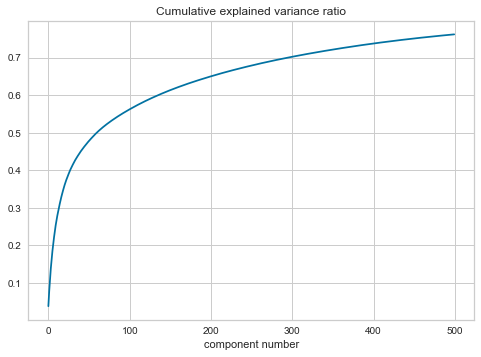

Text(0.5,0,'component number')

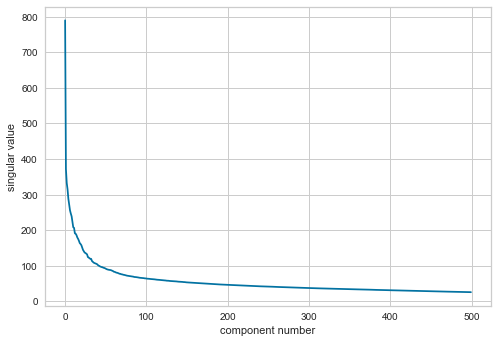

In [104]:
print(tsvd.explained_variance_ratio_.sum())
plt.plot(tsvd.explained_variance_ratio_.cumsum())
plt.title('Cumulative explained variance ratio')
plt.xlabel('component number')
plt.show()
plt.plot(tsvd.singular_values_)
plt.ylabel('singular value')
plt.xlabel('component number')

In [105]:
type(tsvd.components_),tsvd.components_.shape

(numpy.ndarray, (500, 15331))

In [106]:
tsvd.components_.min(),tsvd.components_.max()

(-0.7024619971283844, 0.7890208702102162)

In [107]:
# sns.heatmap(tsvd.components_, cbar=True)

In [108]:
if False:
    plt.plot(tsvd.components_[0,:],label='component 0')
    plt.plot(tsvd.components_[1,:],label='component 1')
    plt.plot(tsvd.components_[2,:],label='component 2')
    plt.plot(tsvd.components_[100,:],label='component 100')
    plt.legend()

****

## Anomaly detection via clustering

### K-Means Clustering

In [109]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [110]:
?KMeans
#KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')

In [111]:
#?MiniBatchKMeans
#MiniBatchKMeans(n_clusters=8, init=’k-means++’, max_iter=100, batch_size=100, verbose=0, compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)

In [112]:
def kmeans_helper(X_,K_values, norm_X=False, comp_silh_score=False):
    Sum_of_squared_distances = []
    silh_scores = [0]
    if norm_X:
        X_ = normalize(X_, norm='l2', axis=1, copy=False, return_norm=False)
    for k in K_values:
        #print(k)
        km = MiniBatchKMeans(n_clusters=k, random_state=5)
        km.fit(X_)
        Sum_of_squared_distances.append(km.inertia_)
        if comp_silh_score and k>1:
            silh_scores.append(silhouette_score(X_, km.labels_, metric='euclidean'))
    plt.plot(K_values,Sum_of_squared_distances)
    plt.title('SSD vs. nb_clusters')
    plt.show()
    if comp_silh_score:
        plt.plot(K_values,silh_scores)
        plt.title('Silhouette Score vs. nb_clusters')
        plt.show()

In [113]:
K_values = range(1,202,3)

In [114]:
%time kmeans_helper(X,K_values)

KeyboardInterrupt: 

In [115]:
# %time kmeans_helper(X,K_values,norm_X = True)

In [116]:
#nb_clusters = 5
#%time km = MiniBatchKMeans(n_clusters=nb_clusters, random_state=2019).fit(X)
#km

### Spectral Clustering

In [117]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
affinity_matrix = cosine_similarity(X)
dist_matrix = 1-affinity_matrix
print(type(affinity_matrix),affinity_matrix.shape,np.min(affinity_matrix),np.max(affinity_matrix))

In [ ]:
#plt.matshow(affinity_matrix, cmap=plt.cm.Blues)
#plt.title("Cosine similarity matrix")

In [ ]:
# force adjacency matrix to be connected
affinity_matrix[affinity_matrix==0] = 1e-10

# put zeros in the diagonal
np.fill_diagonal(affinity_matrix, 0)
affinity_matrix[0:5,0:5]

In [ ]:
#plt.matshow(affinity_matrix, cmap=plt.cm.Blues)
#plt.title("Cosine similarity matrix")

In [ ]:
k0, eigenvalues = autosp.predict_k(affinity_matrix)
k0, eigenvalues[0:5]

In [ ]:
plt.plot(eigenvalues)